In [1]:
import sys
import numpy as np
import librosa
import librosa.display

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import os
import random

from network import *
from util import *
%matplotlib inline
import matplotlib.pyplot as plt

# plt.style.use('ggplot')

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

### Load Model

In [14]:
model_name = '../model/M9_fold' + str(fold_num) + '_v1_epoch160.pkl'
model = torch.load(model_name)

### waveform

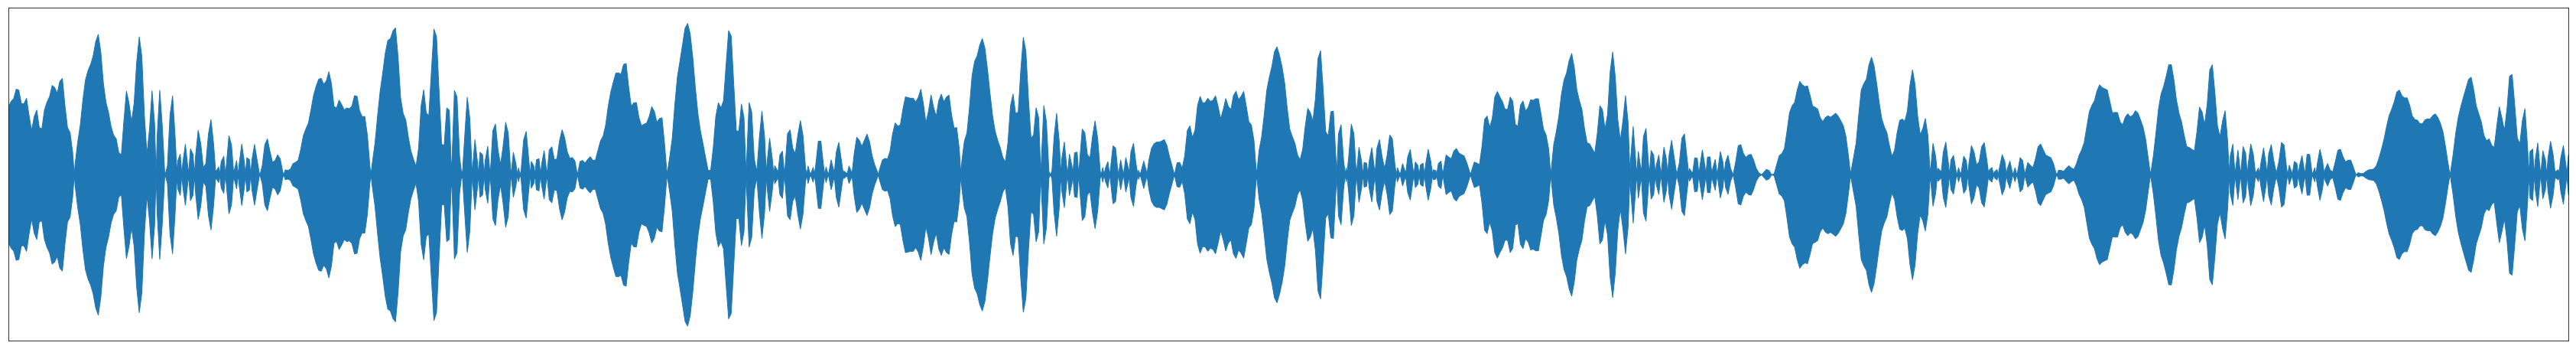

In [10]:
filename = '../ESC-50/301 - Crying baby/4-167077-B.ogg'
y, sr = librosa.load(filename, 44100)
fit = plt.figure(figsize=(60, 8))
# librosa.display.waveplot(y[60000:126150], sr, x_axis=None)
librosa.display.waveplot(y[70000:71000], sr, x_axis=None)
plt.xticks([])
plt.yticks([])
plt.show()

### what filters look like?

In [2]:

conv1_1 = model.conv1_1.weight.data.cpu().numpy()
y = conv1_1[0][0]
print y

[-0.14716524  0.06467009 -0.12007748 -0.24345401 -0.16032353  0.29824993
  0.16263151 -0.12966383 -0.19530833  0.30476043 -0.1190399 ]


### what features after pooling2 look like?

In [52]:


fold_num = 0
testPkl = '../data_wave_44100/fold' + str(fold_num) + '_test.cPickle'
win_size = 66150
stride = int(44100 * 0.2)
sampleSet = load_data(testPkl)

item = sampleSet[120]
label = item['label']
record_data = item['data']
key = item['key']
wins_data = []
maxamp = 0

while maxamp < 0.005:
    j = random.randint(0, len(record_data) - win_size + 1)
    win_data = record_data[j: j+win_size]
    # Continue if cropped region is silent

    maxamp = np.max(np.abs(win_data))
    if maxamp > 0.005:
        break


win_data = win_data[np.newaxis, np.newaxis, :] # [1, 1, 66150]
x = torch.from_numpy(win_data)
print x.size()
x = x.cuda()
x = Variable(x)

x1 = model.relu(model.bn1_1(model.conv1_1(x)))
x2 = model.relu(model.bn1_2(model.conv1_2(x)))
x3 = model.relu(model.bn1_3(model.conv1_3(x)))

x1 = model.relu(model.bn2_1(model.conv2_1(x1)))
x2 = model.relu(model.bn2_2(model.conv2_2(x2)))
x3 = model.relu(model.bn2_3(model.conv2_3(x3)))

x1 = model.pool2_1(x1)
x2 = model.pool2_2(x2)
x3 = model.pool2_3(x3)  # (batchSize, 64L, 441L)

x1 = x1.squeeze(dim=0).data.cpu().numpy()
x2 = x2.squeeze(dim=0).data.cpu().numpy()
x3 = x3.squeeze(dim=0).data.cpu().numpy()

print x1
print x1.shape
print key, id_to_lb(label)


torch.Size([1, 1, 66150])
[[ 0.0999712   0.10110594  0.0885113  ...,  0.38869441  0.20996441
   0.43436852]
 [ 0.50640345  0.60192019  0.51279032 ...,  1.3096832   1.46823478
   1.26575613]
 [ 0.47047541  0.35421607  0.3621673  ...,  0.43109989  0.49057543
   0.47604814]
 ..., 
 [ 0.          0.          0.         ...,  0.33493498  0.26151541
   0.63022149]
 [ 0.          0.          0.         ...,  0.1960624   0.01399873
   0.2634314 ]
 [ 0.          0.          0.         ...,  0.04091172  0.          0.54377306]]
(64, 441)
1-187207-A Crying baby


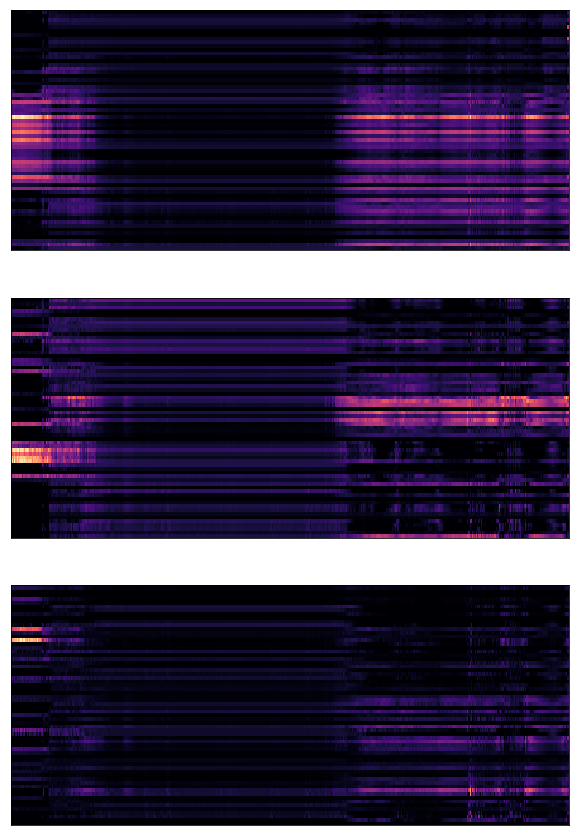

In [53]:
plt.figure(figsize=(10,15))
plt.subplot(3, 1, 1)
librosa.display.specshow(x1)
plt.subplot(3,1,2)
librosa.display.specshow(x2)
plt.subplot(3,1,3)
librosa.display.specshow(x3)
plt.show()

(121, 42)
(121, 42)
(120, 41)
[[-3.   -2.85 -2.7  ...,  2.85  3.    3.15]
 [-3.   -2.85 -2.7  ...,  2.85  3.    3.15]
 [-3.   -2.85 -2.7  ...,  2.85  3.    3.15]
 ..., 
 [-3.   -2.85 -2.7  ...,  2.85  3.    3.15]
 [-3.   -2.85 -2.7  ...,  2.85  3.    3.15]
 [-3.   -2.85 -2.7  ...,  2.85  3.    3.15]]
[[-3.   -3.   -3.   ..., -3.   -3.   -3.  ]
 [-2.95 -2.95 -2.95 ..., -2.95 -2.95 -2.95]
 [-2.9  -2.9  -2.9  ..., -2.9  -2.9  -2.9 ]
 ..., 
 [ 2.9   2.9   2.9  ...,  2.9   2.9   2.9 ]
 [ 2.95  2.95  2.95 ...,  2.95  2.95  2.95]
 [ 3.    3.    3.   ...,  3.    3.    3.  ]]


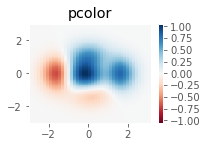

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# make these smaller to increase the resolution
dx, dy = 0.15, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-3, 3 + dy, dy),
                slice(-3, 3 + dx, dx)]
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()


plt.subplot(2, 2, 1)
print x.shape
print y.shape
print z.shape
print x
print y
plt.pcolor(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.title('pcolor')
# set the limits of the plot to the limits of the data
plt.axis([x.min(), x.max(), y.min(), y.max()])
plt.colorbar()